# **Volume 3 Portfolio Project**
## Amber Berry, Sam Carpenter, Spencer Halverson, Kate Wall
## November 2021

Imports here:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
import statsmodels.regression.linear_model as lm
import statsmodels.api as sm

# Sklearn tools
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
life = pd.read_csv('Life_Expectancy_Data.csv')

# Data Cleaning / Feature Engineering / Robustness (25 points): 
**Data Cleaning / Feature Engineering (15 points):**
Take the data from its original form to something that you can work with well.

* Strongly consider using regular expressions and Pandas to organize and format your data.
* Detect and correct (or remove) problems like missing, badly formatted, or incorrect data.
* Justify your choices of what you removed, edited, reformatted, or left unchanged.
* Apply various data handling techniques to engineer additional features that may be useful for answering your research questions. For example, in the titanic data set, you could use titles (miss, mrs., master, mr.) to identify marital status. As another example, in a data set that reports wind direction in degrees, 359 is actually very close to 0, so you might want to add periodic functions of wind angle like sine and cosine to better reflect this.


**Robustness (10 points)**: 

Data cleaning code should be very easy to modify so that it is usable for similar data sets, or so it can handle the same data set but with more data points. Be as general as possible so that as much of your work on this project as possible can be applied to another problem in the future (for example, if you get more data added to your original data set).

In [4]:
# Data cleaning code
# rename columns
life.rename(columns={'Life expectancy ':'Life Expectancy','infant deaths':'Infant Deaths','percentage expenditure':'Percentage Expenditure','Measles ':'Measles',' BMI ':'BMI','under-five deaths ':'Under 5 Deaths','Diphtheria ':'Diptheria',' HIV/AIDS':'HIV/AIDS',' thinness  1-19 years':'Thinness 1-19 years',' thinness 5-9 years':'Thinness 5-9 years','Income composition of resources':'Income Comp'},inplace=True)

Fill nas with neighboring averages for specific country

In [5]:
def clean_na(df):
    col = df.columns
    col = col.drop('Country')
    # get unique countries
    countries = df.Country.unique()
    for country in countries:
        cur_country = df[df.Country==country]
        ind = cur_country.index
        for c in col:
            na_ind = cur_country[cur_country[c].isna()].index
            # proceed with calculations if there are any na values
            if len(na_ind) > 0:
                value_ind = [i for i in ind if i not in na_ind]
                for i in na_ind:
                    # if there is a value in that country in the year before and the year after
                    # fill it with the average between those two
                    if i-1 in value_ind and i+1 in value_ind:
                        df.at[i,c] = np.mean(df.loc[[i-1,i+1],c])
                        # if it is the first or last year, or surrounded by na, just take average of whole column
                    else:
                        df.at[i,c] = np.mean(df.loc[value_ind,c])
    return df

fill nas for averages of developing or developed countries for specified year when the entire column is na. $x^1$

In [6]:
def clean_na_col(df):
    col = df.columns
    col = col.drop('Country')
    # get unique countries
    countries = df.Country.unique()
    for country in countries:
        cur_country = df[df.Country==country]
        ind = cur_country.index
        for c in col:
            na_ind = cur_country[cur_country[c].isna()].index
            # proceed with calculations if there are any na values
            if len(na_ind) > 0:
                value_ind = [i for i in ind if i not in na_ind]
                if len(value_ind) == 0:
                    # developing or developed
                    status = list(cur_country.Status)[0]
                    same_status = df[df.Status==status]
                    # get each year
                    for i in na_ind:
                        year = df.loc[i].Year
                        # find average for respective status and year
                        year_status = same_status[same_status["Year"] == year]
                        df.at[i,c] = np.mean(year_status[c])
    return df

In [7]:
def replace_false_values(df):
    """Replaces false life expectancy values for specific countries/years with the true value (per World Bank) """

    cleaner_life = df.copy()
    
    idx = np.where((cleaner_life['Country'] == 'Nicaragua') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.3
    idx = np.where((cleaner_life['Country'] == 'Kuwait') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 73.1
    idx = np.where((cleaner_life['Country'] == 'Ghana') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 57
    idx = np.where((cleaner_life['Country'] == 'Zimbabwe') & (cleaner_life['Year'] == 2015))
    cleaner_life.at[idx[0],'Life Expectancy'] = 59.5
    idx = np.where((cleaner_life['Country'] == 'Zambia') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 49.8
    idx = np.where((cleaner_life['Country'] == 'Yemen') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.7
    idx = np.where((cleaner_life['Country'] == 'Vanuatu') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 69
    idx = np.where((cleaner_life['Country'] == 'Vanuatu') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 68.8
    idx = np.where((cleaner_life['Country'] == 'Vanuatu') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 68.7
    idx = np.where((cleaner_life['Country'] == 'United Republic of Tanzia') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 62.3
    idx = np.where((cleaner_life['Country'] == 'United Republic of Tanzia') & (cleaner_life['Year'] == 2003))
    cleaner_life.at[idx[0],'Life Expectancy'] = 52.9
    idx = np.where((cleaner_life['Country'] == 'United Kingdom of Great Britain and Northern Ireland') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81
    idx = np.where((cleaner_life['Country'] == 'United Kingdom of Great Britain and Northern Ireland') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.9
    idx = np.where((cleaner_life['Country'] == 'United Kingdom of Great Britain and Northern Ireland') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81
    idx = np.where((cleaner_life['Country'] == 'Ukraine') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.2
    idx = np.where((cleaner_life['Country'] == 'Ukraine') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.9
    idx = np.where((cleaner_life['Country'] == 'Ukraine') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.8
    idx = np.where((cleaner_life['Country'] == 'Uganda') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 59.9
    idx = np.where((cleaner_life['Country'] == 'Turkey') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.6
    idx = np.where((cleaner_life['Country'] == 'Turkey') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70
    idx = np.where((cleaner_life['Country'] == 'Trinidad and Tobago Republic') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 72.4
    idx = np.where((cleaner_life['Country'] == 'Trinidad and Tobago Republic') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 72.2
    idx = np.where((cleaner_life['Country'] == 'Trinidad and Tobago Republic') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 72
    idx = np.where((cleaner_life['Country'] == 'Syrian Arab Republic') & (cleaner_life['Year'] == 2015))
    cleaner_life.at[idx[0],'Life Expectancy'] = 69.9
    idx = np.where((cleaner_life['Country'] == 'Syrian Arab Republic') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 69.8
    idx = np.where((cleaner_life['Country'] == 'Syrian Arab Republic') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.1
    idx = np.where((cleaner_life['Country'] == 'Syrian Arab Republic') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.6
    idx = np.where((cleaner_life['Country'] == 'Switzerland') & (cleaner_life['Year'] == 2003))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Switzerland') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.4
    idx = np.where((cleaner_life['Country'] == 'Switzerland') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.2
    idx = np.where((cleaner_life['Country'] == 'Sweden') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.1
    idx = np.where((cleaner_life['Country'] == 'Sweden') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.9
    idx = np.where((cleaner_life['Country'] == 'Sweden') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'Sweden') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Sweden') & (cleaner_life['Year'] == 2004))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Sweden') & (cleaner_life['Year'] == 2003))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.1
    idx = np.where((cleaner_life['Country'] == 'Suriname') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.7
    idx = np.where((cleaner_life['Country'] == 'Suriname') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.5
    idx = np.where((cleaner_life['Country'] == 'Sudan') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.5
    idx = np.where((cleaner_life['Country'] == 'Sri Lanka') & (cleaner_life['Year'] == 2004))
    cleaner_life.at[idx[0],'Life Expectancy'] = 74.3
    idx = np.where((cleaner_life['Country'] == 'Spain') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.9
    idx = np.where((cleaner_life['Country'] == 'Spain') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'Spain') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'South Sudan') & (cleaner_life['Year'] == 2003))
    cleaner_life.at[idx[0],'Life Expectancy'] = 50.6
    idx = np.where((cleaner_life['Country'] == 'South Sudan') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 50.1
    idx = np.where((cleaner_life['Country'] == 'South Sudan') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 49.2
    idx = np.where((cleaner_life['Country'] == 'South Africa') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 61.1
    idx = np.where((cleaner_life['Country'] == 'Somalia') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 51.5
    idx = np.where((cleaner_life['Country'] == 'Somalia') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 51.2
    idx = np.where((cleaner_life['Country'] == 'Somalia') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 50.9
    idx = np.where((cleaner_life['Country'] == 'Slovenia') & (cleaner_life['Year'] == 2015))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'Slovenia') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.1
    idx = np.where((cleaner_life['Country'] == 'Slovenia') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.3
    idx = np.where((cleaner_life['Country'] == 'Slovenia') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.1
    idx = np.where((cleaner_life['Country'] == 'Singapore') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.1
    idx = np.where((cleaner_life['Country'] == 'Singapore') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80
    idx = np.where((cleaner_life['Country'] == 'Sierra Leone') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 52.4
    idx = np.where((cleaner_life['Country'] == 'Sierra Leone') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 51.7
    idx = np.where((cleaner_life['Country'] == 'Sierra Leone') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 41.4
    idx = np.where((cleaner_life['Country'] == 'Senegal') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.6
    idx = np.where((cleaner_life['Country'] == 'Samoa') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.4
    idx = np.where((cleaner_life['Country'] == 'Samoa') & (cleaner_life['Year'] == 2003))
    cleaner_life.at[idx[0],'Life Expectancy'] = 69.8
    idx = np.where((cleaner_life['Country'] == 'Samoa') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 69.5
    idx = np.where((cleaner_life['Country'] == 'Samoa') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 69.1
    idx = np.where((cleaner_life['Country'] == 'Saint Vincent and the Grenadines') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71
    idx = np.where((cleaner_life['Country'] == 'Saint Vincent and the Grenadines') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.9
    idx = np.where((cleaner_life['Country'] == 'Saint Vincent and the Grenadines') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.8
    idx = np.where((cleaner_life['Country'] == 'Rwanda') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 51
    idx = np.where((cleaner_life['Country'] == 'Rwanda') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.6
    idx = np.where((cleaner_life['Country'] == 'Russian Federation') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.7
    idx = np.where((cleaner_life['Country'] == 'Russian Federation') & (cleaner_life['Year'] == 2015))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.2
    idx = np.where((cleaner_life['Country'] == 'Romania') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71
    idx = np.where((cleaner_life['Country'] == 'Romania') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.2
    idx = np.where((cleaner_life['Country'] == 'Romania') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.2
    idx = np.where((cleaner_life['Country'] == 'Republic of Moldova') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.6
    idx = np.where((cleaner_life['Country'] == 'Republic of Moldova') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.1
    idx = np.where((cleaner_life['Country'] == 'Republic of Korea') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.1
    idx = np.where((cleaner_life['Country'] == 'Republic of Korea') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80
    idx = np.where((cleaner_life['Country'] == 'Republic of Korea') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 79.5
    idx = np.where((cleaner_life['Country'] == 'Cuba') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 76.7
    idx = np.where((cleaner_life['Country'] == 'Chile') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 79.5
    idx = np.where((cleaner_life['Country'] == 'Chile') & (cleaner_life['Year'] == 2015))
    cleaner_life.at[idx[0],'Life Expectancy'] = 79.7
    idx = np.where((cleaner_life['Country'] == 'Canada') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.3
    idx = np.where((cleaner_life['Country'] == 'Portugal') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Portugal') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.4
    idx = np.where((cleaner_life['Country'] == 'Portugal') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.7
    idx = np.where((cleaner_life['Country'] == 'Portugal') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.1
    idx = np.where((cleaner_life['Country'] == 'Paraguay') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.6
    idx = np.where((cleaner_life['Country'] == 'Papua New Guinea') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.8
    idx = np.where((cleaner_life['Country'] == 'Papua New Guinea') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.5
    idx = np.where((cleaner_life['Country'] == 'Norway') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'Norway') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Norway') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.4
    idx = np.where((cleaner_life['Country'] == 'Norway') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.3
    idx = np.where((cleaner_life['Country'] == 'Nigeria') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 49.9
    idx = np.where((cleaner_life['Country'] == 'Nigeria') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 49.4
    idx = np.where((cleaner_life['Country'] == 'Niger') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 50.6
    idx = np.where((cleaner_life['Country'] == 'Niger') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 59.5
    idx = np.where((cleaner_life['Country'] == 'New Zealand') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.9
    idx = np.where((cleaner_life['Country'] == 'New Zealand') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.7
    idx = np.where((cleaner_life['Country'] == 'New Zealand') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.7
    idx = np.where((cleaner_life['Country'] == 'Netherlands') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.1
    idx = np.where((cleaner_life['Country'] == 'Netherlands') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.3
    idx = np.where((cleaner_life['Country'] == 'Netherlands') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Netherlands') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.7
    idx = np.where((cleaner_life['Country'] == 'Myanmar') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 62.7
    idx = np.where((cleaner_life['Country'] == 'Mozambique') & (cleaner_life['Year'] == 2004))
    cleaner_life.at[idx[0],'Life Expectancy'] = 50.1
    idx = np.where((cleaner_life['Country'] == 'Mozambique') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 50.4
    idx = np.where((cleaner_life['Country'] == 'Morocco') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.8
    idx = np.where((cleaner_life['Country'] == 'Mauritania') & (cleaner_life['Year'] == 2004))
    cleaner_life.at[idx[0],'Life Expectancy'] = 61.2
    idx = np.where((cleaner_life['Country'] == 'Mauritania') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 61.4
    idx = np.where((cleaner_life['Country'] == 'Mauritania') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 61.6
    idx = np.where((cleaner_life['Country'] == 'Malta') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.2
    idx = np.where((cleaner_life['Country'] == 'Malta') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.4
    idx = np.where((cleaner_life['Country'] == 'Malta') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'Mali') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 48.8
    idx = np.where((cleaner_life['Country'] == 'Maldives') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71
    idx = np.where((cleaner_life['Country'] == 'Madagascar') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 61.2
    idx = np.where((cleaner_life['Country'] == 'Madagascar') & (cleaner_life['Year'] == 2004))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.8
    idx = np.where((cleaner_life['Country'] == 'Luxembourg') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81
    idx = np.where((cleaner_life['Country'] == 'Luxembourg') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Luxembourg') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Lithuania') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.1
    idx = np.where((cleaner_life['Country'] == 'Lithuania') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.3
    idx = np.where((cleaner_life['Country'] == 'Libya') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.9
    idx = np.where((cleaner_life['Country'] == 'Liberia') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.7
    idx = np.where((cleaner_life['Country'] == 'Latvia') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71
    idx = np.where((cleaner_life['Country'] == 'Latvia') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.9
    idx = np.where((cleaner_life['Country'] == 'Latvia') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.4
    idx = np.where((cleaner_life['Country'] == 'Latvia') & (cleaner_life['Year'] == 2003))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.3
    idx = np.where((cleaner_life['Country'] == 'Kyrgyzstan') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.4
    idx = np.where((cleaner_life['Country'] == 'Kyrgyzstan') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.2
    idx = np.where((cleaner_life['Country'] == 'Italy') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'Italy') & (cleaner_life['Year'] == 2004))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'Israel') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Israel') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Ireland') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.9
    idx = np.where((cleaner_life['Country'] == 'Ireland') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'Ireland') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.7
    idx = np.where((cleaner_life['Country'] == 'Iran') & (cleaner_life['Year'] == 2003))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.3
    idx = np.where((cleaner_life['Country'] == 'Iran') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.6
    idx = np.where((cleaner_life['Country'] == 'Iran') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.2
    idx = np.where((cleaner_life['Country'] == 'Indonesia') & (cleaner_life['Year'] == 2004))
    cleaner_life.at[idx[0],'Life Expectancy'] = 67
    idx = np.where((cleaner_life['Country'] == 'Iceland') & (cleaner_life['Year'] == 2004))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81
    idx = np.where((cleaner_life['Country'] == 'Iceland') & (cleaner_life['Year'] == 2003))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81
    idx = np.where((cleaner_life['Country'] == 'Iceland') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Haiti') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.5
    idx = np.where((cleaner_life['Country'] == 'Guatemala') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.5
    idx = np.where((cleaner_life['Country'] == 'Guatemala') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.1
    idx = np.where((cleaner_life['Country'] == 'Guatemala') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.4
    idx = np.where((cleaner_life['Country'] == 'Guatemala') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.8
    idx = np.where((cleaner_life['Country'] == 'Grenada') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 72.9
    idx = np.where((cleaner_life['Country'] == 'Grenada') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 72.8
    idx = np.where((cleaner_life['Country'] == 'Grenada') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 72.7
    idx = np.where((cleaner_life['Country'] == 'Greece') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.4
    idx = np.where((cleaner_life['Country'] == 'Greece') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.7
    idx = np.where((cleaner_life['Country'] == 'Greece') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Greece') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.3
    idx = np.where((cleaner_life['Country'] == 'Greece') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.4
    idx = np.where((cleaner_life['Country'] == 'Ghana') & (cleaner_life['Year'] == 2010))
    cleaner_life.at[idx[0],'Life Expectancy'] = 61
    idx = np.where((cleaner_life['Country'] == 'Ghana') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.6
    idx = np.where((cleaner_life['Country'] == 'Ghana') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.2
    idx = np.where((cleaner_life['Country'] == 'Germany') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.4
    idx = np.where((cleaner_life['Country'] == 'Germany') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Germany') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Germany') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.1
    idx = np.where((cleaner_life['Country'] == 'Gambia') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.7
    idx = np.where((cleaner_life['Country'] == 'Gambia') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.4
    idx = np.where((cleaner_life['Country'] == 'Gabon') & (cleaner_life['Year'] == 2005))
    cleaner_life.at[idx[0],'Life Expectancy'] = 58.2
    idx = np.where((cleaner_life['Country'] == 'France') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.2
    idx = np.where((cleaner_life['Country'] == 'France') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.1
    idx = np.where((cleaner_life['Country'] == 'France') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.8
    idx = np.where((cleaner_life['Country'] == 'Finland') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Finland') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Finland') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81
    idx = np.where((cleaner_life['Country'] == 'Finland') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.2
    idx = np.where((cleaner_life['Country'] == 'Ethiopia') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.6
    idx = np.where((cleaner_life['Country'] == 'Estonia') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.3
    idx = np.where((cleaner_life['Country'] == 'Estonia') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.4
    idx = np.where((cleaner_life['Country'] == 'El Salvador') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.3
    idx = np.where((cleaner_life['Country'] == 'El Salvador') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 69.4
    idx = np.where((cleaner_life['Country'] == 'Egypt') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.9
    idx = np.where((cleaner_life['Country'] == 'Egypt') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.1
    idx = np.where((cleaner_life['Country'] == 'Egypt') & (cleaner_life['Year'] == 2015))
    cleaner_life.at[idx[0],'Life Expectancy'] = 71.3
    idx = np.where((cleaner_life['Country'] == 'Djibouti') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 59.6
    idx = np.where((cleaner_life['Country'] == 'Denmark') & (cleaner_life['Year'] == 2015))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.7
    idx = np.where((cleaner_life['Country'] == 'Denmark') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.7
    idx = np.where((cleaner_life['Country'] == 'Cyprus') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80
    idx = np.where((cleaner_life['Country'] == 'Cyprus') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.2
    idx = np.where((cleaner_life['Country'] == 'Cyprus') & (cleaner_life['Year'] == 2015))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.3
    idx = np.where((cleaner_life['Country'] == 'Congo') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 56.4
    idx = np.where((cleaner_life['Country'] == 'Comoros') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.4
    idx = np.where((cleaner_life['Country'] == 'Comoros') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 60.7
    idx = np.where((cleaner_life['Country'] == 'Chad') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 50.4
    idx = np.where((cleaner_life['Country'] == 'Central African Republic') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 50.1
    idx = np.where((cleaner_life['Country'] == 'Cabo Verde') & (cleaner_life['Year'] == 2006))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.6
    idx = np.where((cleaner_life['Country'] == 'Canada') & (cleaner_life['Year'] == 2007))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Canada') & (cleaner_life['Year'] == 2008))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.7
    idx = np.where((cleaner_life['Country'] == 'Cabo Verde') & (cleaner_life['Year'] == 2002))
    cleaner_life.at[idx[0],'Life Expectancy'] = 69.6
    idx = np.where((cleaner_life['Country'] == 'Cabo Verde') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 69.1
    idx = np.where((cleaner_life['Country'] == 'Australia') & (cleaner_life['Year'] == 2004))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.5
    idx = np.where((cleaner_life['Country'] == 'Australia') & (cleaner_life['Year'] == 2003))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.2
    idx = np.where((cleaner_life['Country'] == 'Austria') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81
    idx = np.where((cleaner_life['Country'] == 'Austria') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81
    idx = np.where((cleaner_life['Country'] == 'Azerbaijan') & (cleaner_life['Year'] == 2009))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.6
    idx = np.where((cleaner_life['Country'] == 'Bangladesh') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.6
    idx = np.where((cleaner_life['Country'] == 'Bangladesh') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.3
    idx = np.where((cleaner_life['Country'] == 'Belgium') & (cleaner_life['Year'] == 2014))
    cleaner_life.at[idx[0],'Life Expectancy'] = 81.3
    idx = np.where((cleaner_life['Country'] == 'Belgium') & (cleaner_life['Year'] == 2013))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Belgium') & (cleaner_life['Year'] == 2012))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.4
    idx = np.where((cleaner_life['Country'] == 'Belgium') & (cleaner_life['Year'] == 2011))
    cleaner_life.at[idx[0],'Life Expectancy'] = 80.6
    idx = np.where((cleaner_life['Country'] == 'Brazil') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 70.1
    idx = np.where((cleaner_life['Country'] == 'Burkina Faso') & (cleaner_life['Year'] == 2001))
    cleaner_life.at[idx[0],'Life Expectancy'] = 50.9
    idx = np.where((cleaner_life['Country'] == 'Burundi') & (cleaner_life['Year'] == 2000))
    cleaner_life.at[idx[0],'Life Expectancy'] = 49.1
    cleaner_life.at[736,'Life Expectancy'] = 50
    cleaner_life.at[865,'Life Expectancy'] = 55.3
    cleaner_life.at[857,'Life Expectancy'] = 61
    cleaner_life.at[913,'Life Expectancy'] = 65.7
    cleaner_life.at[993,'Life Expectancy'] = 69.9

    return cleaner_life


In [8]:
def replace(group, stds):
    """Give a column `group`, find all values that are more than 3 standard 
    deviations from the mean, and convert those to NaN."""
    group[np.abs(group - group.mean()) > stds * group.std()] = np.nan
    return group

# df is your DataFrame
col = life.columns.drop('Country')
col = col.drop('Status')
life.at[:, col] = life.groupby('Country').transform(lambda g: replace(g, 3))

life = clean_na(life)
life = clean_na_col(life)

# replace false values
life = replace_false_values(life)

life = pd.get_dummies(life, columns=['Status','Country'], drop_first=True)

X = life.drop(columns=['Life Expectancy'])
y = life['Life Expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [9]:
X.head()

,Year,Adult Mortality,Infant Deaths,Alcohol,Percentage Expenditure,Hepatitis B,Measles,BMI,Under 5 Deaths,Polio,Total expenditure,Diptheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income Comp,Schooling,Status_Developing,Country_Albania,Country_Algeria,Country_Angola,Country_Antigua and Barbuda,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,Country_Azerbaijan,Country_Bahamas,Country_Bahrain,Country_Bangladesh,Country_Barbados,Country_Belarus,Country_Belgium,Country_Belize,Country_Benin,Country_Bhutan,Country_Bolivia (Plurinational State of),Country_Bosnia and Herzegovina,...,Country_Singapore,Country_Slovakia,Country_Slovenia,Country_Solomon Islands,Country_Somalia,Country_South Africa,Country_South Sudan,Country_Spain,Country_Sri Lanka,Country_Sudan,Country_Suriname,Country_Swaziland,Country_Sweden,Country_Switzerland,Country_Syrian Arab Republic,Country_Tajikistan,Country_Thailand,Country_The former Yugoslav republic of Macedonia,Country_Timor-Leste,Country_Togo,Country_Tonga,Country_Trinidad and Tobago,Country_Tunisia,Country_Turkey,Country_Turkmenistan,Country_Tuvalu,Country_Uganda,Country_Ukraine,Country_United Arab Emirates,Country_United Kingdom of Great Britain and Northern Ireland,Country_United Republic of Tanzania,Country_United States of America,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela (Bolivarian Republic of),Country_Viet Nam,Country_Yemen,Country_Zambia,Country_Zimbabwe
0,2015,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,83.0,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,86.0,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,89.0,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2012,272.0,69.0,0.01,78.184215,67.0,2787.0,17.6,93.0,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2011,275.0,71.0,0.01,7.097109,68.0,3013.0,17.2,97.0,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Data Visualization and Basic Analysis (15 points)

* Analyze the data, draw conclusions, and effectively communicate your main observations and results.
* Calculate appropriate summary statistics.
* Use appropriate plotting techniques, visualizations, and other tools and techniques you have learned, to thoughtfully identify and evaluate
 - what the data are telling you,
 - how well suited the data are to answering your problem
* Make it pretty

In [ ]:
## Reload all data for basic analysis

life = pd.read_csv('Life_Expectancy_Data.csv')

# Data cleaning code
# rename columns
life.rename(columns={'Life expectancy ':'Life Expectancy','infant deaths':'Infant Deaths','percentage expenditure':'Percentage Expenditure','Measles ':'Measles',' BMI ':'BMI','under-five deaths ':'Under 5 Deaths','Diphtheria ':'Diptheria',' HIV/AIDS':'HIV/AIDS',' thinness  1-19 years':'Thinness 1-19 years',' thinness 5-9 years':'Thinness 5-9 years','Income composition of resources':'Income Comp'},inplace=True)

# call cleaning functions
col = life.columns.drop('Country')
col = col.drop('Status')
life.at[:, col] = life.groupby('Country').transform(lambda g: replace(g, 3))
life = clean_na(life)
life = clean_na_col(life)

# replace false values
life = replace_false_values(life)

## Do not get dummies for countries because we want to use it in our data 
# life = pd.get_dummies(life, columns=['Status','Country'], drop_first=True)

X = life.drop(columns=['Life Expectancy'])
y = life['Life Expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [ ]:
# Describe data's general statistics
life.describe()

,Year,Life Expectancy,Adult Mortality,Infant Deaths,Alcohol,Percentage Expenditure,Hepatitis B,Measles,BMI,Under 5 Deaths,Polio,Total expenditure,Diptheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income Comp,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,68.885822,166.802593,30.304969,4.642647,738.251295,79.746990,2193.398446,39.126031,42.021273,83.478498,5.920043,83.114850,1.742133,7335.544616,1.278354e+07,4.848052,4.881945,0.632623,12.045594
std,4.613841,9.293462,123.748096,117.926249,4.026201,1987.914858,23.958866,11048.438330,19.524563,160.446146,21.807339,2.456137,22.394898,5.077777,13416.126346,5.387202e+07,4.395401,4.485071,0.202836,3.271044
min,2000.000000,39.000000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,62.825000,76.000000,0.000000,1.000000,4.685343,74.000000,0.000000,21.200000,0.000000,79.000000,4.280000,79.000000,0.100000,562.391878,4.189172e+05,1.600000,1.600000,0.507000,10.200000
50%,2008.000000,71.700000,145.000000,3.000000,3.795000,64.912906,89.000000,15.000000,44.100000,4.000000,93.000000,5.721667,93.000000,0.100000,2565.774533,3.556146e+06,3.400000,3.400000,0.673000,12.300000
75%,2012.000000,75.400000,228.750000,22.000000,7.737500,441.534144,96.000000,328.500000,56.300000,27.750000,97.000000,7.430000,97.000000,0.800000,5856.794374,1.227205e+07,7.100000,7.200000,0.780000,14.300000
max,2015.000000,84.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [ ]:
print("Unique Countries:", len(life['Country'].unique()))
print("Occurrences of Each Country:")
print(life['Country'].value_counts())

Unique Countries: 193
Occurrences of Each Country:
Seychelles                                   16
Guyana                                       16
Rwanda                                       16
South Africa                                 16
The former Yugoslav republic of Macedonia    16
                                             ..
Marshall Islands                              1
Monaco                                        1
Saint Kitts and Nevis                         1
Cook Islands                                  1
Palau                                         1
Name: Country, Length: 193, dtype: int64


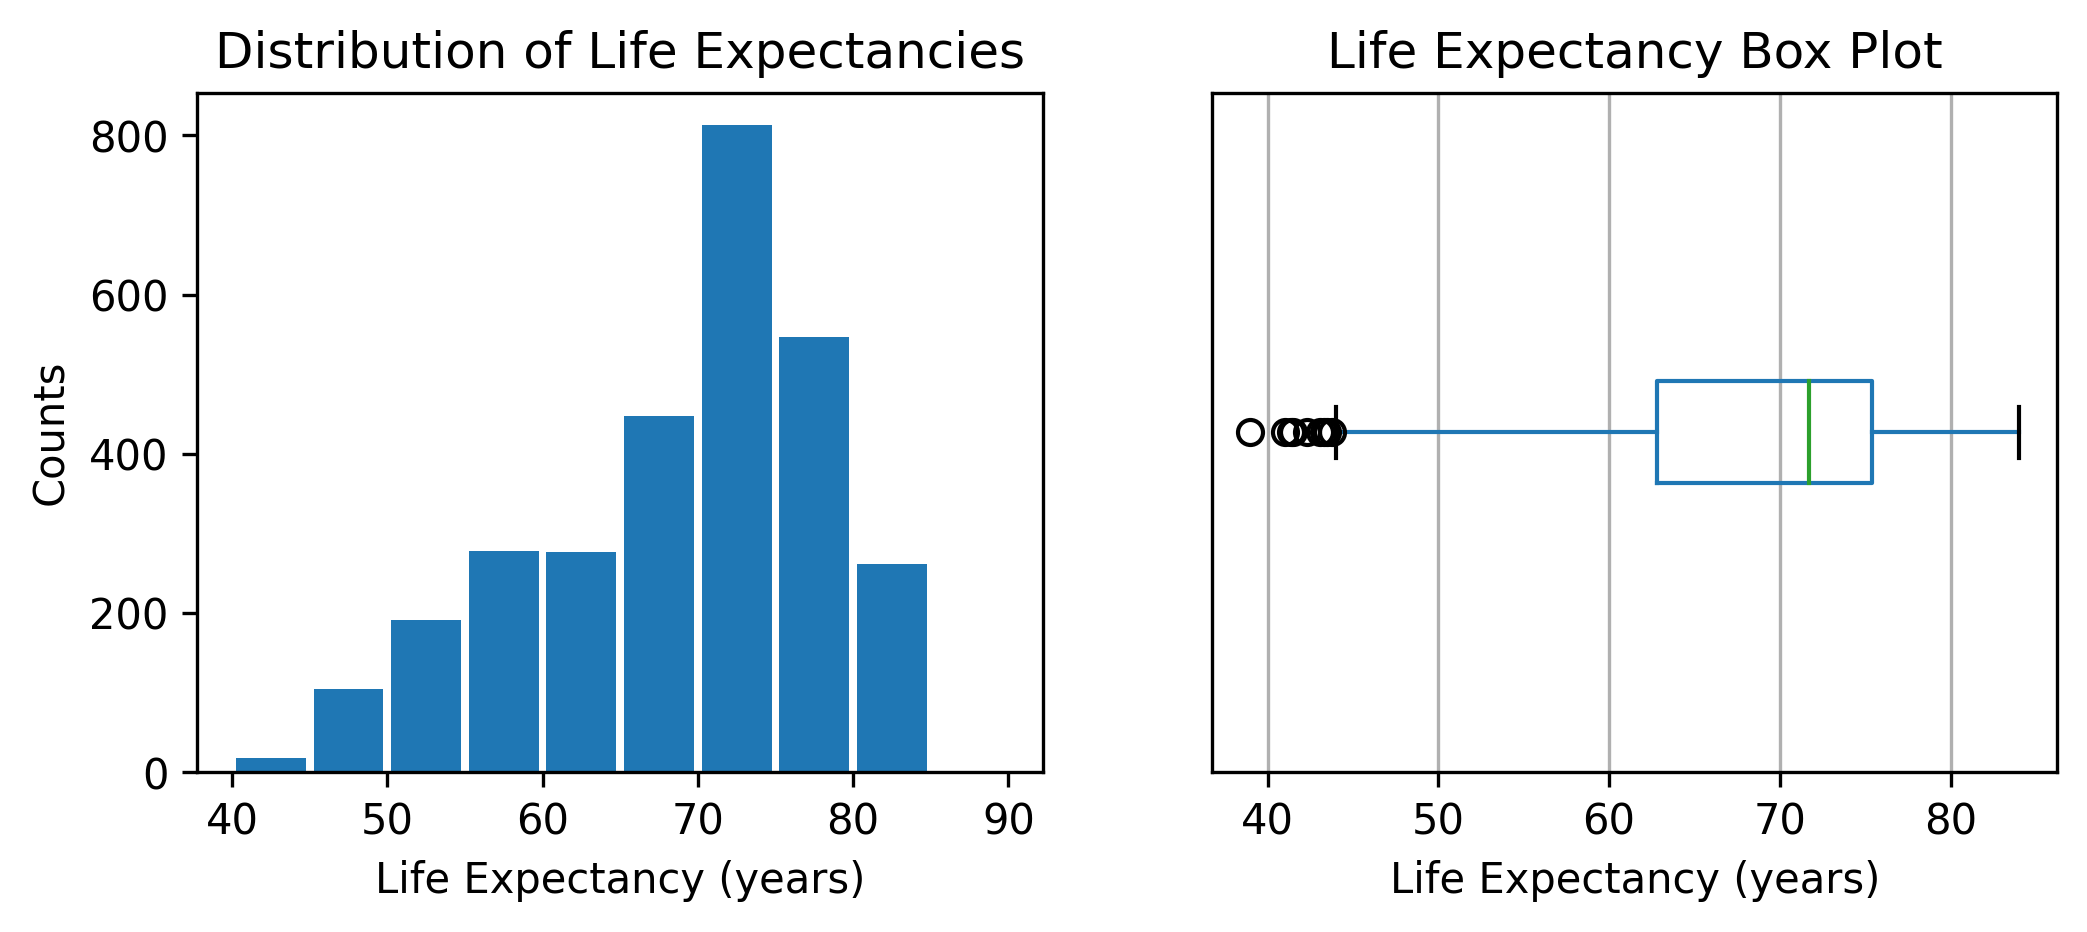

In [ ]:
#plt.figure(figsize=(4,3),dpi=300)
fig, axs = plt.subplots(1, 2,figsize=(8,3),dpi=300)
ax = axs.ravel()

# Histograms
ax[0].hist(life['Life Expectancy'], rwidth=0.9, bins=10, range=(40, 90))
ax[0].set_title("Distribution of Life Expectancies")
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Life Expectancy (years)')
# plt.show()

ax[1] = life.boxplot(column='Life Expectancy',vert=False)
ax[1].set_xlabel('Life Expectancy (years)')
ax[1].set_yticks([])
ax[1].set_title('Life Expectancy Box Plot')
plt.savefig('data_figs.pdf',bbox_inches='tight',pad_inches=0.25)
plt.show()

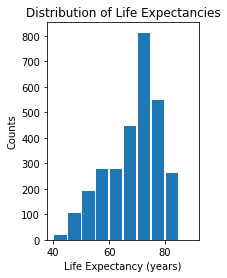

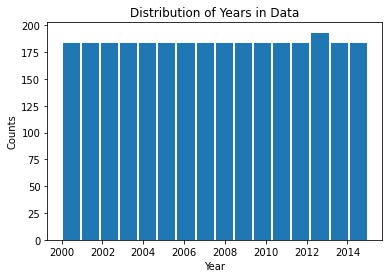

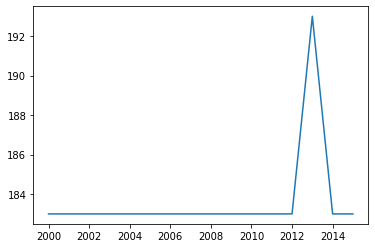

In [ ]:
# Histograms
plt.subplot(121)
plt.hist(life['Life Expectancy'], rwidth=0.9, bins=10, range=(40, 90))
plt.title("Distribution of Life Expectancies")
plt.ylabel('Counts')
plt.xlabel('Life Expectancy (years)')
plt.show()

plt.hist(life['Year'], rwidth=0.9, bins=16)
plt.title("Distribution of Years in Data")
plt.ylabel('Counts')
plt.xlabel('Year')
plt.show()

# Line graph of data points per year
years, counts = np.unique(life['Year'].values, return_counts=True)
plt.plot(years, counts)

In [ ]:
features = ""
for i in life.columns:
    features += i
    features += ", "

print(features)

Country, Year, Status, Life Expectancy, Adult Mortality, Infant Deaths, Alcohol, Percentage Expenditure, Hepatitis B, Measles, BMI, Under 5 Deaths, Polio, Total expenditure, Diptheria, HIV/AIDS, GDP, Population, Thinness 1-19 years, Thinness 5-9 years, Income Comp, Schooling, 


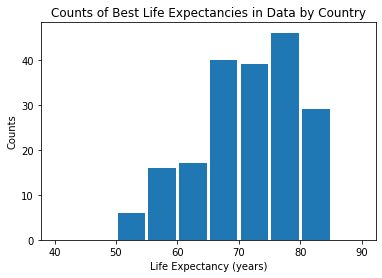

In [ ]:
# Find the best life expectancy for each country
best_life_per_country = life.groupby(['Country'], sort=False)['Life Expectancy'].max()

plt.hist(best_life_per_country, rwidth=0.9, bins=10, range=(40, 90))
plt.title("Counts of Best Life Expectancies in Data by Country")
plt.ylabel('Counts')
plt.xlabel('Life Expectancy (years)')
plt.show()


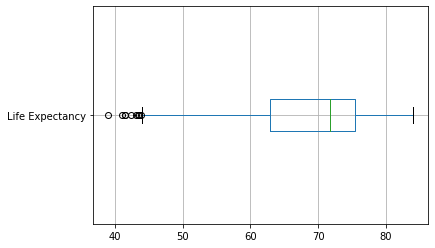

In [ ]:
life.boxplot(column='Life Expectancy', vert=False)
plt.show()

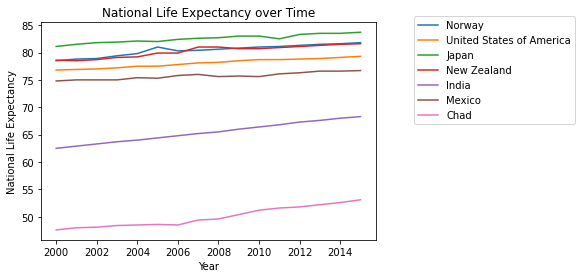

In [ ]:
# countries
countries = {}
choose_countries = ['Norway', 'United States of America',  
                    'Japan', 'New Zealand', 'India', 'Mexico', 'Chad']
for i in choose_countries:
    countries[i] = life[life['Country']==i][['Year', 'Life Expectancy']]

for i in countries.keys():
    plt.plot(countries[i]['Year'], countries[i]['Life Expectancy'], label = i)

plt.title("National Life Expectancy over Time")
plt.xlabel("Year")
plt.ylabel("National Life Expectancy")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('LE_over_time.pdf',bbox_inches='tight',pad_inches=0.25)
plt.show()

## Feature Importance

In [ ]:
# Correlation Matrix (compute R^2 between every feature)
tol = 0.5
corr = life.corr()
# print(corr)
correlated_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if corr.iloc[i, j] > tol:
            correlated_pairs.append([life.columns[i], life.columns[j], "{:.2e}".format(corr.iloc[i, j])])
            # correlated_pairs.append([life.columns[i], life.columns[j]])

for i in correlated_pairs:
    print(i)

print(corr.loc['Life Expectancy', 'Adult Mortality'])

['Year', 'Hepatitis B', '5.99e-01']
['Year', 'BMI', '5.07e-01']
['Year', 'Polio', '5.11e-01']
['Year', 'Thinness 1-19 years', '7.28e-01']
['Year', 'Thinness 5-9 years', '7.43e-01']
['Status', 'Total expenditure', '5.26e-01']
['Life Expectancy', 'Percentage Expenditure', '5.20e-01']
['Life Expectancy', 'Measles', '9.97e-01']
['Life Expectancy', 'HIV/AIDS', '5.48e-01']
['Adult Mortality', 'Thinness 5-9 years', '5.49e-01']
['Infant Deaths', 'Diptheria', '8.74e-01']
['Alcohol', 'BMI', '5.29e-01']
['Alcohol', 'Polio', '6.25e-01']
['Percentage Expenditure', 'Measles', '5.26e-01']
['Hepatitis B', 'Thinness 1-19 years', '5.26e-01']
['Hepatitis B', 'Thinness 5-9 years', '5.64e-01']
['Measles', 'HIV/AIDS', '5.36e-01']
['BMI', 'Polio', '7.00e-01']
['GDP', 'Population', '9.38e-01']
['Thinness 1-19 years', 'Thinness 5-9 years', '8.03e-01']
-0.7159563010263288


To find the most important features, run OLS, look at summary stats
and remove the feature with the highest p-value if its confidence interval 
contains 0.

 Rerun the model and repeat until all the features have p < 0.05.

Results: We found that dropping Population, Hepatitis B, Thinness 5-9 years, Year and Total Expenditure lowered both the AIC and BIC on the linear regression. Dropping Thinness 1-19 years further lowered the BIC. This suggests that these features may be correlated to other remaining features, and they are not very important to keep.

In [ ]:
X_f = pd.get_dummies(X, columns=['Status'], drop_first=True)
X_f = X_f.drop(columns=['Country'])
X_f['const'] = 1
y_f = y.copy()

In [ ]:
results = sm.OLS(y_f,X_f).fit()
print("AIC:",results.aic)
print("BIC:", results.bic)
print(results.summary())

AIC: 15940.034317185866
BIC: 16065.729488677276
                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     814.8
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:03:38   Log-Likelihood:                -7949.0
No. Observations:                2938   AIC:                         1.594e+04
Df Residuals:                    2917   BIC:                         1.607e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
X_f = X_f.drop(columns=['Population'])
results = sm.OLS(y_f,X_f).fit()
print("AIC:",results.aic)
print("BIC:", results.bic)
print(results.summary())


AIC: 15938.099419166043
BIC: 16057.80910630072
                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     857.9
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:03:39   Log-Likelihood:                -7949.0
No. Observations:                2938   AIC:                         1.594e+04
Df Residuals:                    2918   BIC:                         1.606e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [ ]:
X_f = X_f.drop(columns=['Hepatitis B'])
results = sm.OLS(y_f,X_f).fit()
print("AIC:",results.aic)
print("BIC:", results.bic)
print(results.summary())

AIC: 15936.25693016094
BIC: 16049.981132938883
                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     905.8
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:03:40   Log-Likelihood:                -7949.1
No. Observations:                2938   AIC:                         1.594e+04
Df Residuals:                    2919   BIC:                         1.605e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [ ]:
X_f = X_f.drop(columns=['Thinness 5-9 years'])
results = sm.OLS(y_f,X_f).fit()
print("AIC:",results.aic)
print("BIC:", results.bic)
print(results.summary())

AIC: 15934.60852960552
BIC: 16042.34724802673
                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     959.3
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:03:40   Log-Likelihood:                -7949.3
No. Observations:                2938   AIC:                         1.593e+04
Df Residuals:                    2920   BIC:                         1.604e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [ ]:
X_f = X_f.drop(columns=['Year'])
results = sm.OLS(y_f,X_f).fit()
print("AIC:",results.aic)
print("BIC:", results.bic)
print(results.summary())

AIC: 15933.370545044942
BIC: 16035.123779109417
                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     1019.
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:03:41   Log-Likelihood:                -7949.7
No. Observations:                2938   AIC:                         1.593e+04
Df Residuals:                    2921   BIC:                         1.604e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
X_f = X_f.drop(columns=['Total expenditure'])
results = sm.OLS(y_f,X_f).fit()
print("AIC:",results.aic)
print("BIC:", results.bic)
print(results.summary())

AIC: 15933.360992294343
BIC: 16029.128742002085
                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     1087.
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:04:22   Log-Likelihood:                -7950.7
No. Observations:                2938   AIC:                         1.593e+04
Df Residuals:                    2922   BIC:                         1.603e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
X_f = X_f.drop(columns=['Thinness 1-19 years'])
results = sm.OLS(y_f,X_f).fit()
print("AIC:",results.aic)
print("BIC:", results.bic)
print(results.summary())

AIC: 15934.351837276768
BIC: 16024.134102627775
                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     1163.
Date:                Fri, 03 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:04:38   Log-Likelihood:                -7952.2
No. Observations:                2938   AIC:                         1.593e+04
Df Residuals:                    2923   BIC:                         1.602e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:

results = sm.OLS(y_f,X_f).fit()

# Learning Algorithms and In-depth Analysis (15 points)
Analyze the data using the techniques discussed in class. Explain what research questions you can answer using the techniques presented this semester.

Be able to explain the results of your analysis, whether the results are meaningful, and why you chose the tools that you used.  

*Important note: It is more important to use the statistical and machine learning tools thoughtfully,  correctly, and honestly than it is to "get the result" that you hoped for.  If there is no evidence of an effect, there is no shame in that, but you must honestly admit it and show the careful work that led you to that conclusion.  If the algorithms cannot predict what you wanted them to predict, be honest about that.  The worst thing to do would be to try to make your results look stronger than they really are by doing sloppy work, by omitting important analysis, data, or plots, or by falsifying data or results.*

In [10]:
# Reload all data for models

life = pd.read_csv('Life_Expectancy_Data.csv')

# Data cleaning code
# rename columns
life.rename(columns={'Life expectancy ':'Life Expectancy','infant deaths':'Infant Deaths','percentage expenditure':'Percentage Expenditure','Measles ':'Measles',' BMI ':'BMI','under-five deaths ':'Under 5 Deaths','Diphtheria ':'Diptheria',' HIV/AIDS':'HIV/AIDS',' thinness  1-19 years':'Thinness 1-19 years',' thinness 5-9 years':'Thinness 5-9 years','Income composition of resources':'Income Comp'},inplace=True)

# call cleaning functions
col = life.columns.drop('Country')
col = col.drop('Status')
life.at[:, col] = life.groupby('Country').transform(lambda g: replace(g, 3))
life = clean_na(life)
life = clean_na_col(life)

# replace false values
life = replace_false_values(life)

life = pd.get_dummies(life, columns=['Status','Country'], drop_first=True)

X = life.drop(columns=['Life Expectancy'])
y = life['Life Expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [11]:
def evaluate_model(model, param_grid, X_train, X_test, y_train, y_test):
    # Grid Search
    model_gs = GridSearchCV(model, param_grid, n_jobs=-1)
    model_gs.fit(X_train, y_train)

    # Results
    model_gs_score = model_gs.score(X_test, y_test)
    model_gs_best = model_gs.best_estimator_
    model_gs_best_params = model_gs.best_params_
    model_gs_best_index = model_gs.best_index_

    # Calculate error of test set
    model_predictions = model_gs_best.predict(X_test)
    model_mse = mean_squared_error(y_test, model_predictions)
    model_mae = mean_absolute_error(y_test, model_predictions)

    def my_score(y_test,y_pred,sd=8.796834):
        diff = np.abs(y_pred-y_test)
        true = diff[diff<sd/2]
        return len(true)/len(y_test)

    accuracy = my_score(y_test, model_predictions)

    return model_gs, accuracy, model_gs_score, model_gs_best, model_gs_best_params, model_gs_best_index, model_gs_best_index, model_mse, model_mae

## Linear Regression

In [12]:
# Linear Regression (OLS) Sklearn version

param_grid = {"normalize": [True, False]}

# Model
lin_reg = LinearRegression()

# Results
lin_reg_gs, lin_reg_gs_accuracy, lin_reg_gs_score, lin_reg_gs_best, lin_reg_gs_best_params, lin_reg_gs_best_index, lin_reg_gs_best_index, lin_reg_mse, lin_reg_mae = evaluate_model(lin_reg,
                                                                                                                                                                param_grid,
                                                                                                                                                                X_train,
                                                                                                                                                                X_test,
                                                                                                                                                                y_train,
                                                                                                                                                                y_test)
print("MSE: " + str(lin_reg_mse))
print("MAE: " + str(lin_reg_mae))
print("Score: " + str(lin_reg_gs_score))
print("Accuracy: " + str(lin_reg_gs_accuracy))

MSE: 1.6966782785169008
MAE: 0.8020692503365938
Score: 0.9794268078549161
Accuracy: 0.9807256235827665


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


In [13]:
lin = lin_reg.fit(X_train, y_train)
lin_pred = lin.predict(X_test)
np.save("Linear_Reg_Pred.npy", lin_pred)
np.save("Linear_Reg_y_test.npy", y_test)

In [14]:
ls

Life_Expectancy_Data.csv  Linear_Reg_y_test.npy
Linear_Reg_Pred.npy       sample_data/


## Logistic Regression

In [16]:
# Logistic Regression

life['age bin'] = 40.
ages = [45.,50.,55.,60.,65.,70.,75.,80.,85.]
for age in ages:
    mask = life['Life Expectancy'] >= age
    life.loc[mask,'age bin'] = age
y_bins = life['age bin']

X_train_bins, X_test_bins, y_train_bins, y_test_bins = train_test_split(life.drop(columns=['Life Expectancy','age bin']), y_bins,test_size=.3)

param_grid = {"penalty": ['none','l2'],
              "solver":['newton-cg','lbfgs'],
              "C":[1,.1],
              "multi_class": ['ovr','multinomial']
              }

# Model
log_reg = LogisticRegression( max_iter=1000)


log_gs = GridSearchCV(log_reg, param_grid, n_jobs=-1)
log_gs.fit(X_train_bins, y_train_bins)
log_best = log_gs.best_estimator_

print(log_gs.best_params_)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

{'C': 1, 'multi_class': 'ovr', 'penalty': 'none', 'solver': 'newton-cg'}


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

In [ ]:
MSEs = []
MAEs = []
scores = []
for _ in range(10):
  X_train_bins, X_test_bins, y_train_bins, y_test_bins = train_test_split(life.drop(columns=['Life Expectancy','age bin']), y_bins,test_size=.3)
  log_best.fit(X_train_bins, y_train_bins)
  score = log_best.score(X_test_bins,y_test_bins)

  pred = log_best.predict(X_test_bins)

  mse = mean_squared_error(y_test_bins,pred)
  mae = mean_absolute_error(y_test_bins,pred)
  MSEs.append(mse)
  MAEs.append(mae)
  scores.append(score)

print(f'MSE: {np.mean(MSEs)}, MAE: {np.mean(MAEs)}, score: {np.mean(scores)}')

In [ ]:
fparams

In [ ]:
# Ridge Regression

life['age bin'] = 40.
ages = [45.,50.,55.,60.,65.,70.,75.,80.,85.]
for age in ages:
    mask = life['Life Expectancy'] >= age
    life.loc[mask,'age bin'] = age
y_bins = life['age bin']

X_train_bins, X_test_bins, y_train_bins, y_test_bins = train_test_split(life.drop(columns=['Life Expectancy','age bin']), y_bins,test_size=.3)


param_grid = {"normalize": [True, False],
              "alpha": [10**i for i in range(-8, 4)],
              "solver":['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}


# Model
ridge_reg = Ridge()

# Results
ridge_reg_gs, ridge_reg_accuracy, ridge_reg_gs_score, ridge_reg_gs_best, ridge_reg_gs_best_params, ridge_reg_gs_best_index, ridge_reg_gs_best_index, ridge_reg_mse, ridge_reg_mae = evaluate_model(ridge_reg,
                                                                                                                                                                                param_grid,
                                                                                                                                                                                X_train_bins,
                                                                                                                                                                                X_test_bins,
                                                                                                                                                                                y_train_bins,
                                                                                                                                                                                y_test_bins)
print("MSE: " + str(ridge_reg_mse))
print("MAE: " + str(ridge_reg_mae))
print("Score: " + str(ridge_reg_gs_score))
print("Accuracy: " + str(ridge_reg_accuracy))

In [ ]:
print(ridge_reg_gs_best_params)

In [ ]:
# Lasso Regression

param_grid = {"normalize": [True, False],
              "alpha": [10**i for i in range(-8, 4)]}

# Model
lasso_reg = Lasso()

# Results
lasso_reg_gs, lasso_reg_gs_score, lasso_reg_gs_best, lasso_reg_gs_best_params, lasso_reg_gs_best_index, lasso_reg_gs_best_index, lasso_reg_mse, lasso_reg_mae = evaluate_model(lasso_reg,
                                                                                                                                                                            param_grid,
                                                                                                                                                                            X_train_bins,
                                                                                                                                                                            X_test_bins,
                                                                                                                                                                            y_train_bins,
                                                                                                                                                                            y_test_bins)

print("MSE: " + str(lasso_reg_mse))
print("MAE: " + str(lasso_reg_mae))
print("Score: " + str(lasso_reg_gs_score))

In [ ]:
print(lasso_reg_gs_best_params)

In [ ]:
lasso_reg = Lasso(alpha=.0001, normalize=False).fit(X_train, y_train)
coeffs = lasso_reg.coef_
non_zero_feature_indices = [i for i, coef in enumerate(coeffs) if abs(coef) > .00001]
zero_feature_indices = [i for i, coef in enumerate(coeffs) if abs(coef) < .00001]
print(coeffs[:20])
print("Significant feature indices: " + str(non_zero_feature_indices))
print("Insignificant feature indices: " + str(zero_feature_indices))

In [ ]:
# Lasso Regression with dropped columns

param_grid = {"normalize": [True, False],
              "alpha": [10**i for i in range(-8, 4)]}

# Model
lasso_reg = Lasso()

X_train_bins_dropped = X_train_bins.copy()
X_train_bins_dropped.drop(X_train_bins.columns[zero_feature_indices], axis=1, inplace=True)

X_test_bins_dropped = X_test_bins.copy()
X_test_bins_dropped.drop(X_test_bins.columns[zero_feature_indices], axis=1, inplace=True)

# Results
lasso_reg_gs, lasso_reg_gs_score, lasso_reg_gs_best, lasso_reg_gs_best_params, lasso_reg_gs_best_index, lasso_reg_gs_best_index, lasso_reg_mse, lasso_reg_mae = evaluate_model(lasso_reg,
                                                                                                                                                                            param_grid,
                                                                                                                                                                            X_train_bins_dropped,
                                                                                                                                                                            X_test_bins_dropped,
                                                                                                                                                                            y_train_bins,
                                                                                                                                                                            y_test_bins)

print("MSE: " + str(lasso_reg_mse))
print("MAE: " + str(lasso_reg_mae))
print("Score: " + str(lasso_reg_gs_score))

In [ ]:
# ElasticNet Regression

param_grid = {"normalize": [True, False],
              "alpha": [10**i for i in range(-8, 4)],
              "l1_ratio":[.1*i for i in range(1, 10)]}

# Model
elast_reg = ElasticNet()

# Results
elast_reg_gs, elast_reg_gs_score, elast_reg_gs_best, elast_reg_gs_best_params, elast_reg_gs_best_index, elast_reg_gs_best_index, elast_reg_mse, elast_reg_mae = evaluate_model(elast_reg,
                                                                                                                                                                            param_grid,
                                                                                                                                                                            X_train_bins,
                                                                                                                                                                            X_test_bins,
                                                                                                                                                                            y_train_bins,
                                                                                                                                                                            y_test_bins)
print("MSE: " + str(elast_reg_mse))
print("MAE: " + str(elast_reg_mae))
print("Score: " + str(elast_reg_gs_score))

## Random Forest


## Etc.